In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import Activacion as act
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

## Fondo
Defino las direcciones de los fondos, según detector de germanio. Elijo con *det*, y cargo los espectros en '.txt'.

In [ ]:
path_fondo = {'DF-OFF': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/DF_fondo_rOFF_12.06.2025.txt",
              'XC-OFF': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_fondo_rOFF_12.06.2025.txt",
              'DF-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/DF_fondo_rON_10.06.2025.txt",
              'XC-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_fondo_rON_10.06.2025.txt"}

det = 'XC-OFF'

r_is = det.split('-')[1]

Fondo = {'OFF': act.fromspec(path_fondo[det.split('-')[0]+'-OFF']),
         'ON': act.fromspec(path_fondo[det.split('-')[0]+'-ON'])}

## Eficiencia

Defino las direcciones para los espectros de Eu y las tablas con las ROIs.

In [ ]:
path_Eu152 = {'DF-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/DF_Eu152_76044A_sep3_rON_11.06.2025.txt",
              'XC-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_Eu152_76044A_3sep_rON_11.06.2025.txt",
              'XC-OFF': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_Eu152_76044A_3sep_rOFF_12.06.2025.txt"}
path_Roical = {'DF-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/ROI_cal_DF_Eu152_rON.txt",
               'XC-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/ROI_cal_XC_Eu152_rON.txt",
               'XC-OFF': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/ROI_cal_XC_Eu152_rOFF.txt"}

In [ ]:
ROIs_cal = np.loadtxt(path_Roical[det]) #llamo a las ROIs definidas
spec_cal = act.fromspec(path_Eu152[det]) #recupero el espectro

In [ ]:
Fuente_pat = 'Eu152_76044A-440'
Fecha_cal = datetime.strptime(path_Eu152[det][-14:-4], '%d.%m.%Y') #día de la calibración. Puede definirse a mano, o cambiarse el formato de la fecha.
datos_cal = act.NAA_calib(Fuente_pat, Fecha_cal) #datos de la fuente pat - actividad, hl, espectro gamma (energy, intensity, unc_int)

Epeak_Eu = ROIs_cal[:, 0]
ROIs_cal = ROIs_cal[:, 1:].astype(int)

### Ajuste a curva de eficiencia

In [ ]:
grado_pol = 1 #grado de polinomio

eff_fit = datos_cal.cal_eff(ROIs_cal, spec_cal, Fondo[r_is], grado_pol, criterio = 0.003)

eff_data, err_eff, coef, coef_err, chi2, data_sel, residual, pvalor, ddof, rhos, var_mus = eff_fit #desglosamiento de resultados

coef_tabla = np.vstack((coef, coef_err)).T

Grafico los resultados

In [ ]:
E_arr = np.linspace(Epeak_Eu.min(), Epeak_Eu.max(), num=1000)
logE_arr  = np.log(E_arr)
eff_eval = np.polyval(coef, logE_arr) #eff evaluada con parámetros del ajuste
sigma_mu_est = np.sqrt(var_mus(logE_arr)) #raiz de la función varianza en función de ln(E)

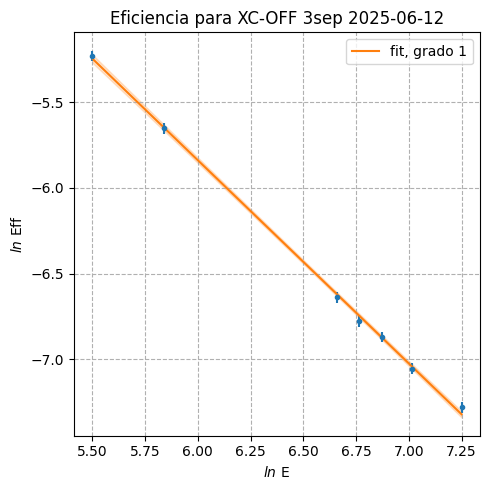

In [ ]:
plt.figure(1, figsize = (5,5))
plt.errorbar(np.log(Epeak_Eu), np.log(eff_data), yerr= err_eff/eff_data, fmt='.')
plt.plot(logE_arr, eff_eval, label = 'fit, grado {}'.format(grado_pol))
plt.fill_between(logE_arr, eff_eval-sigma_mu_est, eff_eval+sigma_mu_est, color='tab:orange', alpha=0.2)
plt.grid(True, ls = '--')
plt.ylabel('$ln$ Eff')
plt.xlabel('$ln$ E')
plt.legend()
plt.title('Eficiencia para ' + f'{det}'+ ' 3sep ' + f'{Fecha_cal.date()}')
plt.tight_layout()

### Reporte Eficiencia

In [ ]:
for jj in range(len(coef)):
    print(f'a{grado_pol-jj} = '+ ' '.join([*act.redondeo(coef[jj], coef_err[jj], 2, texto=True)]))
print(f'χ2 = {chi2}, ddof = {ddof}, p-value = {pvalor}.')#' \n Válido en E = ({Epeak_Eu.min().round(2)}-{Epeak_Eu.max().round(2)}) keV')

a1 = -1.187 ± 0.020 keV^-1
a0 = 1.28 ± 0.13 keV^-0
χ2 = 3.281414847854652, ddof = 5, p-value = 0.6566882398021794.


##Pico incógnita

###137Cs

Ruta del espectro en .txt

In [ ]:
path_incog = {'DF-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/DF_Cs137_76072_sep3_rON_11.06.2025.txt",
              'XC-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_Cs137_76072_3sep_rON_11.06.2025.txt",
              'XC-OFF': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_Cs137_76071_3sep_rOFF_12.06.2025.txt"}

Defino la **fuente incógnita** a considerar.

In [ ]:
iso = '137Cs'
fuente = {'DF-ON': 'Cs137_76072-440',
          'XC-ON': 'Cs137_76072-440',
          'XC-OFF': 'Cs137_76071-440'}  #'Co60_76057-440'

**ROI** del pico incógnita. Se define a partir de mirar el pico en la energía que esperamos.

In [ ]:
n_back = 3

ROIs = {'DF-ON': {iso: [1160, 1174]},
        'XC-ON': {iso: [1108, 1122]},
        'XC-OFF': {iso: [1109, 1121]}}

Defino la fuente como un **alambre de composición 100% del radioisótopo**. Esto es para que sea una variable con las mismas funciones definidas (métodos) que las de un alambre.

In [ ]:
Comp_incog = {iso: 1}
Incog = act.Alambre(Comp_incog, 0)

Datos y **Tasa de Fondo** en la ROI del pico de interés.

In [ ]:
ROIs = ROIs[det]
Fondo_ROIs = {mat:Fondo[r_is].ROI(ROIs[mat], n_bkg=n_back) for mat in ROIs}
cps_Fondo = {mat:np.array([Fondo_ROIs[mat][xx] for xx in ['net', 'net_err']])/Fondo[r_is].tlive for mat in ROIs}

**Espectro de la incógnita**, y datos en la ROI antes definida.

In [ ]:
spec_incog = act.fromspec(path_incog[det], coef_en = spec_cal.coef_en[::-1])
pico_incog = spec_incog.ROI(list(ROIs.values())[0], n_bkg=n_back)
E_incog = pico_incog['en_max'] #energía del pico
t_inicio = spec_incog.tinicio.replace(hour=0, minute=0, second=0, microsecond=0) #Fecha de espectro '00 hs'

**Tasa neta de**l pico **incógnita** en la ROI.

In [ ]:
cps_pico = np.array([pico_incog['net'], pico_incog['net_err']])/spec_incog.tlive - cps_Fondo[iso]

Actividad calculada, actividad reportada, y la **diferencia relativa porcentual**.

In [ ]:
Act_incog, Act_RA3, diff, BR_incog = act.Actividad(np.array([E_incog]), np.array([cps_pico[0]]), np.array([cps_pico[1]]),
                          spec_incog.treal, coef_tabla, isfromRA3=True, Fuente=fuente[det], dt = t_inicio,
                          var_mu = var_mus)

####Resultados

In [ ]:
print(f' Act calc = {Act_incog[0][0].round(-2)}±{Act_incog[0][1].round(-2)} Bq\n Act reportada = {Act_RA3[0].round(-2)}±{Act_RA3[1].round(-2)} Bq\n diff = {diff[0].round(2)}%')

 Act calc = 25400.0±300.0 Bq
 Act reportada = 25300.0±800.0 Bq
 diff = 0.39%


###60Co

Repito para esta otra fuente

In [ ]:
path_incog_Co = {'DF-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/DF_Co60_76057_sep3_rON_11.06.2025.txt",
                 'XC-OFF': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_Co60_76057_3sep_rOFF_12.06.2025.txt",
                 'XC-ON': "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/2025-06-11_NAAPG_Beam/11.06.2025_PG_LINT/-txt/XC_Co60_76057_3sep_rON_11.06.2025.txt"}
iso_Co = '60Co'
fuente_Co = 'Co60_76057-440'

ROIs_Co = {'DF-ON': {iso_Co: np.array([[2370, 2388], [2082, 2100]])},
           'XC-ON': {iso_Co: np.array([[1992, 2006], [2268, 2282]])},
           'XC-OFF': {iso_Co: np.array([[1993, 2007], [2268, 2282]])}}

Incog_Co = act.Alambre({iso_Co: 1}, 0)

ROIs_Co = ROIs_Co[det]
Fondo_ROIs[iso_Co] = [Fondo[r_is].ROI(ROIs_Co[iso_Co][ii], n_bkg=n_back) for ii in range(2)]
cps_Fondo[iso_Co] = [np.array([Fondo_ROIs[iso_Co][ii][xx] for xx in ['net', 'net_err']])/Fondo[r_is].tlive for ii in range(2)]

spec_incog_Co = act.fromspec(path_incog_Co[det], coef_en = spec_cal.coef_en[::-1])
pico_incog_Co = [spec_incog_Co.ROI(list(ROIs_Co.values())[0][ii]) for ii in range(2)]
E_incog_Co = [pico_incog_Co[ii]['en_max'] for ii in range(2)] #energía del pico


In [ ]:
np.array(E_incog_Co)

array([1172.76111022, 1332.51254108])

In [ ]:
cps_pico_Co = [np.array([pico_incog_Co[ii]['net'], pico_incog_Co[ii]['net_err']])/spec_incog_Co.tlive - cps_Fondo[iso_Co][ii] for ii in range(2)]
Act_incog_Co, Act_RA3_Co, diff_Co, BR_incog_Co = act.Actividad(np.array(E_incog_Co), np.array(cps_pico_Co)[:, 0], np.array(cps_pico_Co)[:, 1],
                          spec_incog_Co.treal, coef_tabla, isfromRA3=True, Fuente=fuente_Co, dt = spec_incog_Co.tinicio.replace(hour=0, minute=0, second=0, microsecond=0),
                          var_mu = var_mus)


####Resultados

In [ ]:
Act_incog_Co, Act_RA3_Co, diff_Co, BR_incog_Co

(array([[18908.45532111,   306.42708797],
        [19173.28541221,   343.86066812]]),
 array([18272.47148282,   548.17414448]),
 array([3.42014447, 4.81042316]),
 array([[1.173228e+03, 9.985000e-01, 3.000000e-04],
        [1.332492e+03, 9.998260e-01, 6.000000e-06]]))

##Agregar datos a la curva de eficiencia

A partir de *BR_incog*, *Act_RA3*, y *cps_pico*, puedo calcular nuevos valores de eficiencia, y sumarlos a *eff_data*.

In [ ]:
n_new = 3
eff_data = np.append(eff_data, np.zeros(n_new))
err_eff = np.append(err_eff, np.zeros(n_new))
Epeak_Eu = np.append(Epeak_Eu, np.zeros(n_new))

### 137Cs

In [ ]:
eff_incog = cps_pico[0]/(Act_RA3[0]*BR_incog[0][1])
eff_incog_err = eff_incog*np.sqrt(np.divide(*BR_incog[0][1:][::-1])**2 +
                                  np.divide(*cps_pico[::-1])**2 +
                                  np.divide(*Act_RA3[::-1])**2)

In [ ]:
eff_data[-3] = eff_incog
err_eff[-3] = eff_incog_err
Epeak_Eu[-3] = E_incog

###60Co

In [ ]:
cps_pico_Co = np.array(cps_pico_Co)

eff_data[-2:] = np.array(cps_pico_Co)[:, 0]/(Act_RA3_Co[0]*BR_incog_Co[:, 1])
err_eff[-2:] = eff_incog*np.sqrt((BR_incog_Co[:, 2]/BR_incog_Co[:, 1])**2 +
              (cps_pico_Co[:, 1]/cps_pico_Co[:, 0])**2 + np.divide(*Act_RA3[::-1])**2)
Epeak_Eu[-2:] = E_incog_Co

Repito el cálculo del ajuste, con estas nuevas series de datos.

In [ ]:
grado_pol = 1 #grado de polinomio

coef, coef_err, chi2, residual, pvalor, ddof, rhos, var_mus = act.ajuste_pol(grado_pol, np.log(Epeak_Eu), np.log(eff_data), err_eff/eff_data)

E_arr = np.linspace(Epeak_Eu.min(), Epeak_Eu.max(), num=1000)
logE_arr  = np.log(E_arr)
eff_eval = np.polyval(coef, logE_arr) #eff evaluada con parámetros del ajuste
sigma_mu_est = np.sqrt(var_mus(logE_arr)) #raiz de la función varianza en función de ln(E)

In [ ]:
for jj in range(len(coef)):
    print(f'a{grado_pol-jj} = '+ ' '.join([*act.redondeo(coef[jj], coef_err[jj], 3, texto=True)]))
print(f'χ2 = {chi2}, ddof = {ddof}, p-value = {pvalor}.')#' \n Válido en E = ({Epeak_Eu.min().round(2)}-{Epeak_Eu.max().round(2)}) keV')

a1 = -1.1822 ± 0.0190 keV^-1
a0 = 1.254 ± 0.126 keV^-0
χ2 = 3.9897587456767365, ddof = 8, p-value = 0.8580462776497138.


In [ ]:
print('χ2 red = ', chi2/ddof)

χ2 red =  0.49871984320959206


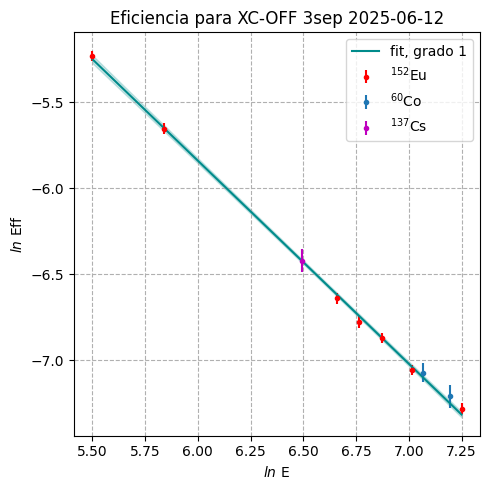

In [ ]:
plt.figure(1, figsize = (5,5))

plt.errorbar(np.log(Epeak_Eu[:-3]), np.log(eff_data[:-3]), yerr= err_eff[:-3]/eff_data[:-3], fmt='r.', label = '$^{152}$Eu')
plt.errorbar(np.log(Epeak_Eu[-2:]), np.log(eff_data[-2:]), yerr= err_eff[-2:]/eff_data[-2:], fmt='.', label = '$^{60}$Co')
plt.errorbar(np.log(Epeak_Eu[-3]), np.log(eff_data[-3]), yerr= err_eff[-3]/eff_data[-1], fmt='m.', label = '$^{137}$Cs')

plt.plot(logE_arr, eff_eval, 'darkcyan' , label = 'fit, grado {}'.format(grado_pol))
plt.fill_between(logE_arr, eff_eval-sigma_mu_est, eff_eval+sigma_mu_est, color='darkcyan', alpha=0.2)
plt.grid(True, ls = '--')
plt.ylabel('$ln$ Eff')
plt.xlabel('$ln$ E')
plt.legend()
plt.title('Eficiencia para ' + f'{det}'+ ' 3sep ' + f'{Fecha_cal.date()}')
plt.tight_layout()

In [ ]:
coef_tabla = np.vstack((coef, coef_err)).T
coef_tabla

array([[-1.18218793,  0.01904496],
       [ 1.25425229,  0.12568254]])

In [ ]:
err_eff

array([1.64535220e-04, 1.08878750e-04, 4.08842089e-05, 3.92106096e-05,
       3.21669832e-05, 2.70564795e-05, 2.12418135e-05, 4.93445304e-05,
       4.92079614e-05, 4.92465919e-05])

## Todas las Eff. juntas

En cada iteración, para los distintos *det*, me anoto los coeficientes que devuelve, junto con los datos para ajustar. Esto último resultará útil para volver a obtener la función *var_mu*, para propagar errores.

In [ ]:
data_all = {'XC-OFF': np.array([[0.00535819, 0.0035099 , 0.00130789, 0.00114144, 0.00103678,
       0.00086166, 0.00068793, 0.00162549, 0.00084879, 0.00073996], [1.64535220e-04, 1.08878750e-04, 4.08842089e-05, 3.92106096e-05,
       3.21669832e-05, 2.70564795e-05, 2.12418135e-05, 4.93445304e-05,
       4.92079614e-05, 4.92465919e-05]]).T,
            'XC-ON': ,
            'DF-ON': }

In [ ]:
coef_all = {'XC-OFF': np.array([[-1.18218793,  0.01904496], [ 1.25425229,  0.12568254]]),
            'XC-ON': ,
            'DF-ON': }


##Flujo a partir de hojuelas Mn